In [227]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from datetime import date

#gamma function and integration
from scipy import special, optimize
from scipy import integrate
from scipy import stats


#Fitting the spectrum
from scipy.optimize import curve_fit


#Using csv tables
import pandas as pd

#Astropy module to handle units
import astropy
from astropy.io import ascii
from astropy import units as u
from astropy.units import Quantity
from astropy import constants as const

#Importing the constant that will be needed
from astropy.constants import c, k_B, m_e, e

golden = (1 + 5 ** 0.5) / 2

# Data selection

First, let's get the data that will be fitted.

In [346]:
data_rec = astropy.io.ascii.read(os.path.join('AT2019azh_radio_observations.dat'), guess=True)

#Replacing MJD time data to days since detection
data_rec['Time (MJD)']=data_rec['Time (MJD)']- 58528
data_rec.rename_column('Time (MJD)', 'Days since detection')
#Convert uJy to mJy
data_rec['Flux density (uJy)']= 1e-3*data_rec['Flux density (uJy)']
data_rec['Flux density error (uJy)']= 1e-3*data_rec['Flux density error (uJy)']
data_rec.rename_column('Flux density (uJy)', 'Flux density (mJy)')
data_rec.rename_column('Flux density error (uJy)', 'Flux density error (mJy)')

Let's make a plot to visualize the data.

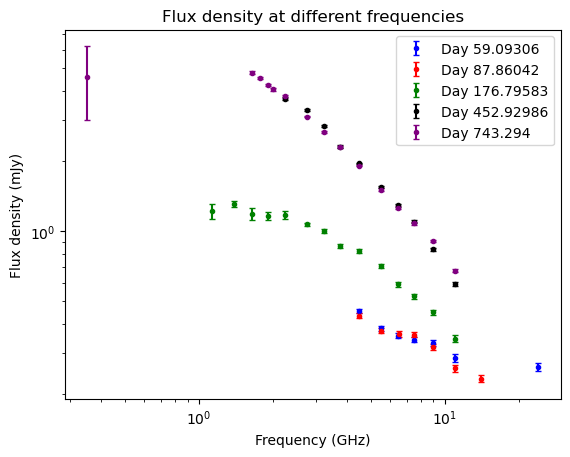

In [229]:
#For the plot lets go trhought rows and plotting each day in a colour
fig, ax = plt.subplots()
NumberOfDates=5
date_list=[]
for i in np.arange(0,NumberOfDates):
    date_list.append([[], [], []])

for freq in data_rec:
    day= round(freq['Days since detection'],5)
    Frequency=freq['Frequency (GHz)']
    Flux=freq['Flux density (mJy)']
    FluxErr=freq['Flux density error (mJy)']
    if day ==  59.09306:
        ax.errorbar(Frequency, Flux, yerr= FluxErr, 
                     fmt= '.',capsize= 2 , c='blue', zorder=8, label= f'Day {day}' )
        date_list[0][0].append(Frequency)
        date_list[0][1].append(Flux)
        date_list[0][2].append(FluxErr)
    if day ==  87.86042:
        ax.errorbar(Frequency, Flux, yerr= FluxErr, 
                     fmt= '.',capsize= 2 , c='red', zorder=8, label= f'Day {day}' )
        date_list[1][0].append(Frequency)
        date_list[1][1].append(Flux)
        date_list[1][2].append(FluxErr)
    if day ==  176.79583:
        ax.errorbar(Frequency, Flux, yerr= FluxErr, 
                     fmt= '.',capsize= 2 , c='green', zorder=8, label= f'Day {day}' )
        date_list[2][0].append(Frequency)
        date_list[2][1].append(Flux)
        date_list[2][2].append(FluxErr)
    if day ==  452.92986:
        ax.errorbar(Frequency, Flux, yerr= FluxErr, 
                     fmt= '.',capsize= 2 , c='black', zorder=8, label= f'Day {day}' )
        date_list[3][0].append(Frequency)
        date_list[3][1].append(Flux)
        date_list[3][2].append(FluxErr)
    if day == 743.294:
        ax.errorbar(Frequency, Flux, yerr= FluxErr, 
                     fmt= '.',capsize= 2 , c='purple', zorder=8, label= f'Day {day}' )
        date_list[4][0].append(Frequency)
        date_list[4][1].append(Flux)
        date_list[4][2].append(FluxErr)

#Function to only plot labels once
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

legend_without_duplicate_labels(ax)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(f"Frequency (GHz)")
plt.ylabel(f'Flux density (mJy)')
plt.title('Flux density at different frequencies')
plt.show()

# 1. Synchrotron functions

In [230]:
#Defininf Pacholcyzk's constants
c1=(const.e.esu*3/(4*np.pi*const.m_e.cgs**3*const.c.cgs**5)).cgs.value

c3=(const.e.esu**3*np.sqrt(3)/(4*np.pi*const.m_e.cgs*const.c.cgs**2)).cgs.value

def Pacholcyzk5(p):
    """
    Pacholcyzk5 returns the value of the Pacholcyzk c5 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c5: Value of the constant
    """
    c5=3**0.5/(16*np.pi)*(const.e.esu**3/(const.m_e*const.c**2))*(p+7/3)/(p+1)*scipy.special.gamma((3*p-1)/12)*scipy.special.gamma((3*p+7)/12)
    #return only the value in cgs units to make possible a fit
    return c5.cgs.value
    
def Pacholcyzk6(p):
    """
    Pacholcyzk6 returns the value of the Pacholcyzk c6 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c6: Value of the constant
    """
    c6=np.pi*3**0.5/(72)*const.e.esu*const.m_e**5*const.c**10*(p+10/3)*scipy.special.gamma((3*p+2)/12)*scipy.special.gamma((3*p+10)/12)
    return c6.cgs.value

In arXiv:1301.6759 we can see that the energy is minimized when (330-340 en sjoert son clave para esto y el cut off)
$$
    E_B=\frac{6}{11}E_e,
$$
with
$$
        \frac{E_e}{V}=\frac{N_e}{V} m_e c^2 \gamma_e= N_0 \int  E E^{-p}dE ~~~~~~ \frac{E_B}{V}= \frac{B^2}{8\pi}.
$$
So we can define a function that computes the electron density from the magnetic field.
$$
            N_0=\frac{11}{6} \left( \frac{8\pi}{B^2}  E\int E^{-p}dE \right)^{-1} = \frac{6}{11} \frac{(2-p) B^2}{8\pi}  \left( \frac{1}{E_{max}^{2-p} -E_{min}^{2-p}} \right)
$$

In [231]:
def N0fromB(B, fV, R, p, Emax=1e6*(const.m_e.cgs*const.c.cgs**2).value, Emin=(const.m_e.cgs*const.c.cgs**2).value):
    """
    Gives the electron number density for a synchtron source assuming equipartition energy 
    from the radius and magnetic field
    
    Parameters
    :B: Magnetic field of the source
    :fV: Volume filling factor for the geometry 4/3 for a cone
    :R: Radius of the source
    :Emax: Maximun energy of the relativistic electrons
    :Emin: Minimun energy of the relativistic electrons

    Output
    :N0: Electron number density at the given magnetic field and radius
    """

    N0= 11/6*(2-p)*B**2/(8*np.pi)*1/(Emax**(2-p)-Emin**(2-p))

    return N0

In [232]:
def SynchrotronEmissionCoeff(p, B, N0, frequency):
    """
    Returns the emission coefficient for a synchrotron emisison of a population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the emission coefficient want to be calculated

    Output
    :EmissionCoeff: Emission coefficient value
    """

    EmissionCoeff=Pacholcyzk5(p)*N0*B**((p+1)/2)*(frequency/(2*c1))**((1-p)/2)
    return EmissionCoeff

def SynchrotronAbsorptionCoeff(p, B, N0, frequency):
    """
    Returns the absorption coefficient for a synchrotron population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the absorption coefficient want to be calculated

    Output
    :AbsorptionCoeff: absorption coefficient value
    """

    AbsorptionCoeff=Pacholcyzk6(p)*N0*B**((p+2)/2)*(frequency/(2*c1))**(-(p+4)/2)
    return AbsorptionCoeff

def SourceFuncSynch(p, B, N0, frequency):
    """
    returns the value of the source function for a given frequency

    Parameters
    :p: Exponent of the power law of electron population
    :B: Value of the magnetic field
    :N0: Constant of the power law
    :Ne: Thermal electron number density
    :Te: Temperature of the electrons
    :frequency: frequency at which the source function want to be calculated
    
    Output
    :S: Value of the source function at the given frequency
    """

    S=SynchrotronEmissionCoeff(p, B, N0, frequency)/(SynchrotronAbsorptionCoeff(p, B, N0, frequency))
    return S


def SpecIntSynch(p, B, N, radius, frequency):
    """
    SpecIntSynch returns the specific intensity of a population of relativistic electrons driven by a power law at a given
    frequency

    Paramenters
    :p: exponent of the power law
    :B: Magnetic field
    :N: Constant of the power law
    :radius: Radius of the emiting region
    :frequency: frequency at which the specific intensity is computed

    Output
    :I: specific intensity at the given frequency
    """

    S = SourceFuncSynch(p, B, N, frequency)
    kappa= SynchrotronAbsorptionCoeff(p, B, N, frequency)
    
    I=S*(1 - np.exp(-radius*kappa))
    return I

def solidangle(radius, distance):
    """
    solidangle gives the solid angle of a source at distance d and size r in the small angle approximation.If units are 
    desired at the output, they must be inserted in the parameters with unit module

    Parameters
    :radius: radius of the source
    :distance: distance from Earth to source

    Outputs
    :omega: solid angle of the source
    """
    #Applying the expresion for the solid angle in the small angle approximation
    omega= np.pi * (radius**2)/(distance**2)
    return omega

def FluxatTSynch(frequency, r, p, B, distance, F0, alpha):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :frequency: frequency at which the specific intensity is computed
    :p: exponent of the power law describing electron population
    :B: Magnetic field at the epoch
    :N: Constant of the power law at the epoch
    :distance: Distance to the source
    :F0: Steady radio emission from the host galaxy+
    :alpha: Base flux of the hsot galaxy power law exponent
    
    Output
    :F: Flux of the source
    """
    B= 10**B
    r=10**r
    Fbase= F0*(frequency/1.28e9)**(alpha)
    N=N0fromB(B, 1.15, r, p)
    
    F=Fbase + solidangle(r, distance)*SpecIntSynch(p, B, N, r, frequency)*1e23*1e3 # to convert to cgs units
    return F #In order to get from cgs to Jy


In [233]:
def freqtowavelenght(frequency):
    """
    Transforms from frequency to wavelenght

    Parameters
    :frequency: Input frequency

    Output
    :wavelenght:
    """
    frequency=frequency.to(u.Hz)
    return (const.c/frequency).decompose()

def wavelenghttofreq(wavelenght):
    """
    Transforms from wavelenght to frequency

    Parameters
    :wavelenght: Input wavelenght

    Output
    :frequency:
    """
    wavelenght=wavelenght.to(u.m)
    return (const.c/wavelenght).decompose()

# 2. Fit to the Data

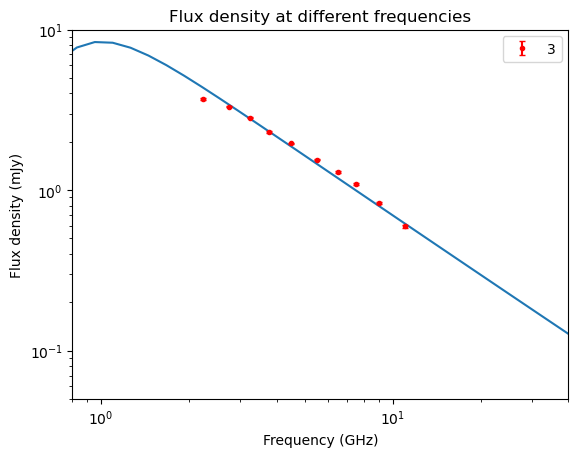

In [336]:
#Input parameters
freqcont= np.logspace(-1, 2, base=10) #In mHz
distance= ((96*u.Mpc).to(u.cm)).value 


F0= 0.2
alpha= -0.87

num_times=len(date_list)
B=np.ones(num_times)
N=np.ones(num_times)
R=np.ones(num_times)
#Ussually p is fixed but GoodWing argue that for this TDE it is observed that it is not
p=np.ones(num_times)

B[4]= (0.04*u.G).value
R[4]= (7e17*u.cm).value
p[4]=3.2

B[3]= (0.07*u.G).value
R[3]= (5e17*u.cm).value
p[3]=3.5

B[2]= (0.08*u.G).value
R[2]= (9.5e16*u.cm).value
p[2]=2.6

B[1]= (0.35*u.G).value
R[1]= (1.85e16*u.cm).value
p[1]=2.9

B[0]= (0.4*u.G).value
R[0]= (1.4e16*u.cm).value
p[0]=2.7

#Since this amgnitudes have quite different values (orders of magnitude) we give them to the functions as teh log
B= np.log10(B)
R= np.log10(R)

#select date
i=3
F= FluxatTSynch(freqcont*1e9 , R[i], p[i], B[i], distance, F0, alpha)
plt.plot(freqcont, F)
plt.errorbar(date_list[i][0], date_list[i][1], yerr=  date_list[i][2],fmt= '.',capsize= 2 , c='red',
             zorder=8, label= f'{i}')
     

plt.yscale('log')
plt.xscale('log')
plt.xlabel(f"Frequency (GHz)")
plt.ylabel(f'Flux density (mJy)')
plt.title('Flux density at different frequencies')
plt.legend()
plt.xlim(left=0.8, right= 40) 
plt.ylim(bottom=0.5e-1, top=10)
plt.show()

In [337]:
def leastsq_function(params, *args):
    """
    
    """
    #Time independent parameters
    F0 = params[0]
    alpha= params[1]
    num_times= args[1]
    
    #Time dependent parameters
    B = np.ones(num_times)
    R= np.ones(num_times)
    p= np.ones(num_times)
    for i in np.arange(0, num_times):
        B[i] = params[2+i]
        R[i] = params[2+i + num_times]
        p[i] = params[2+i + 2*num_times]


    #Arguments
    frequency = args[0]
    distance = args[2]
    FluxValue= args[3]
    FLuxErr= args[4]

    like=0
    #Fit each time
    for i in np.arange(0, num_times):
        for j in np.arange(0, len(frequency[i])):
            FluxFit= FluxatTSynch(frequency[i][j]*1e9 , R[i], p[i], B[i], distance, F0, alpha)
            like= like + np.abs((FluxValue[i][j] - FluxFit)/FLuxErr[i][j])
    return like

In [338]:
#Input parameters
freqcont= np.logspace(-1, 2, base=10) #In mHz
distance= ((96*u.Mpc).to(u.cm)).value 
num_times=3

freq = []
FluxValue = []
FluxErr = []

#Saving the data at each epoch in arrays
for time in date_list[1:]:
    freq.append(time[0])
    FluxValue.append(time[1])
    FluxErr.append(time[2])

#params0=(F0, alpha, B[0], B[1], B[2], B[3], R[0], R[1], R[2], R[3], p[0], p[1], p[2], p[3])
params0=(F0, alpha, B[1], B[2], B[3], R[1], R[2], R[3], p[1], p[2], p[3])
args0=(freq, num_times, distance, FluxValue, FluxErr)
"""
params0=(F0, alpha, B[1], R[1], p[1])
args0=(freq[1], 1, distance, FluxValue[1], FluxErr[1])
"""
result = scipy.optimize.least_squares(leastsq_function, x0 = params0, args=args0)

/tmp/ipykernel_110773/1254638252.py:74: RuntimeWarning: overflow encountered in exp
  I=S*(1 - np.exp(-radius*kappa))


In [340]:
print('Time dependend parameters')
print(10**result['x'][2:])
print('Log(Time dependend parameters)')
print(result['x'][2:])
print('Time independend parameters')
print(result['x'][:2])

Time dependend parameters
[3.49046064e-01 8.09769254e-02 7.00994049e-02 1.84618805e+16
 9.59045482e+16 5.00439281e+17 7.95070856e+02 3.96208422e+02
 3.15768130e+03]
Log(Time dependend parameters)
[-0.45711725 -1.09163872 -1.15428567 16.26627594 16.9818392  17.69935139
  2.90040583  2.5979237   3.4993683 ]
Time independend parameters
[ 0.20028869 -0.86989182]


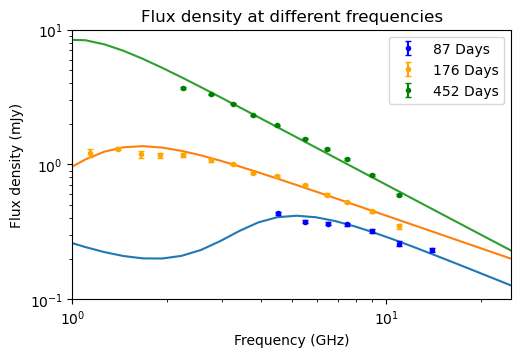

In [348]:
sizefig=3.5
plt.figure(figsize=(sizefig*golden, sizefig))

for i in np.arange(0, num_times):
    F= FluxatTSynch(freqcont*1e9 , result['x'][2 + num_times + i], result['x'][2 + 2*num_times + i], result['x'][2+i]
                    , distance, result['x'][0], result['x'][1])
    
    plt.plot(freqcont, F)



plt.errorbar(date_list[1][0], date_list[1][1], yerr=  date_list[1][2],fmt= '.',capsize= 2 , c='blue',
             zorder=8, label='87 Days')
plt.errorbar(date_list[2][0], date_list[2][1], yerr=  date_list[2][2],fmt= '.',capsize= 2 , c='orange',
             zorder=8, label='176 Days')
plt.errorbar(date_list[3][0], date_list[3][1], yerr=  date_list[3][2],fmt= '.',capsize= 2 , c='green',
             zorder=8,label='452 Days')
#plt.errorbar(date_list[3][0], date_list[3][1], yerr=  date_list[3][2],fmt= '.',capsize= 2 , c='red',
#             zorder=8,label= '743 Days')


plt.yscale('log')
plt.xscale('log')
plt.xlabel(f"Frequency (GHz)")
plt.ylabel(f'Flux density (mJy)')
plt.title('Flux density at different frequencies')
plt.legend()
plt.xlim(left=1, right= 25) 
plt.ylim(bottom=0.1, top=10)
plt.show()